## 기초 모듈 불러오기

In [1]:
#!pip install -U imbalanced-learn
#!pip install lightgbm

In [2]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from soynlp.normalizer import *
from hanspell import spell_checker
from konlpy.tag import Okt

# ML
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

##### 시각화 한글화 

In [3]:
import platform
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import koreanize_matplotlib 
path = "C:/Windows/Fonts/malgun.ttf"

if platform.system() == "Darwin":
    print("Hangul set complete in your MAC!")
    rc("font", family = "Arial Unicode MS")
    
elif platform.system() == "Windows":
    print("Hangul set complete in your Windows!")
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc("font", family = font_name)

else:
    print("Unknown your system....")
    
plt.rcParams["axes.unicode_minus"] = False

def seaborn_Hangul():
    ## seaborn 한글
    plt.rc("font", family = "Malgun Gothic")
    sns.set(font="Malgun Gothic", 
    rc={"axes.unicode_minus":False}, style='white')
seaborn_Hangul();

Hangul set complete in your Windows!


## 리뷰 전처리 데이터 가져오기
- 명사 + 형태소 기준으로 작업
- 말뭉치 만들기
- 말뭉치 기준 벡터화 

In [4]:
# 파일 불러오기

review_df = pd.read_csv('./MK_review_proceed_data.csv', encoding='utf-8', index_col=0) # df_review는 전체년도 리뷰 크롤링 파일
review_df.head(1)

,date,review,tokenized_review,tokenized_removed_review,reviews_for_vectorize,noun_tokenized_review,noun_tokenized_removed_review,noun_reviews_for_vectorize,rating,label
0,2023-09-10,상세 설명에 들어가지 않아도 검색 결과에서 중량과 가격이 바로 확인되면 더 편리하겠습니다,"['상세', '설명', '에', '들어가지', '않아도', '검색', '결과', '...","['상세', '설명', '들어가지', '않아도', '검색', '결과', '중량', ...",상세 설명 들어가지 않아도 검색 결과 중량 가격 확인 되면 더 편리하겠습니다,"['상세', '설명', '검색', '결과', '중량', '가격', '바로', '확인...","['상세', '설명', '검색', '결과', '중량', '가격', '확인', '더']",상세 설명 검색 결과 중량 가격 확인 더,5,1.0


리뷰 -> 토큰화 -> 불용어 처리 -> 벡터화 사전작업
```
review 
    -> tokenized_review  (명사+형태소)
        -> tokenized_removed_review
            -> reviews_for_vectorize
            
    -> noun_tokenized_review  (명사)
        -> noun_tokenized_removed_review
            -> noun_reviews_for_vectorize
```

##### 말뭉치 만들기

In [5]:
## 말뭉치 만들기##### 말뭉치 만들기

import ast

nouns_list = []

for tokens in review_df['tokenized_removed_review']:
    
    nouns_list.extend(ast.literal_eval(tokens))
    
nouns_list_set = list(set(nouns_list))
print('토큰화 말뭉치 개수 :',len(nouns_list))
print('중복을 제거한 말뭉치 개수 :',len(nouns_list_set))

토큰화 말뭉치 개수 : 122378
중복을 제거한 말뭉치 개수 : 12527


## smote 
smote는 오버샘플링의 일종이다.(Over-Sampling)
Over-Sampling은 말 그대로 데이터의 수를 Over하게 만드는 기법입니다. 샘플링을 하는 목적은 다수 클래스와 소수 클래스의 비율을 맞춰주기 위함이며 오버샘플링은 소수 클래스의 데이터를 다수 클래스와 일정 비율로 맞춰주는 작업이다.
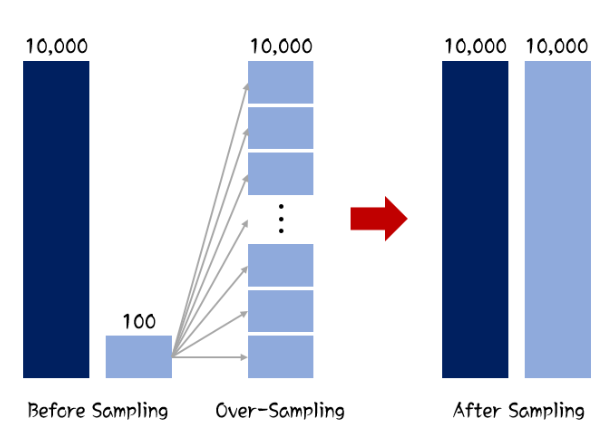


## smote의 특이점
기존 Over-Sampling은 기존 데이터를 랜덤 복원추출하는 작업으로 진행한다.이러한 기존 오버샘플링과의 중요한 차이점은 
###### 기존의 데이터를 랜덤으로 복원 추출하는 것이 아니라 기존의 데이터들을 적절하게 조합 하여 새로운 데이터를 만들어낸다는 것입니다. 
어떻게 그런 일이 가능할까?
우선 소수 클래스의 데이터 중 임의의 데이터 한 개를 기준으로 잡고 해당 데이터와 가장 가까운 거리에 있는 k개의 데이터를 찾습니다. 이때 k개의 데이터는 모두 소수 클래스의 데이터입니다. 그리고 선별된 데이터들과 처음 기준으로 잡았던 데이터와의 연결선 상에 새로운 데이터를 만들어냅니다.
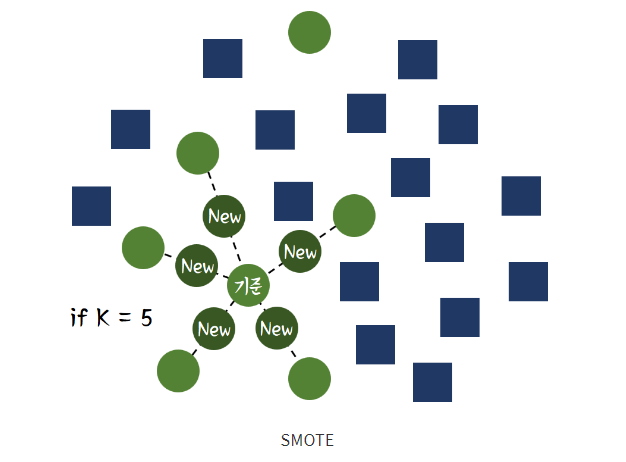


## smote의 하이퍼 파라미터
sampling_strategy =  float, str, dict 또는 callable, 기본값='auto'

만약에 float 자료형으로  0.8을 주었다 -> 소수/다수 의 비율이 0.8이 되도록 리샘플링하겠다는 뜻

str은 다음과 같은 방식이 있다.
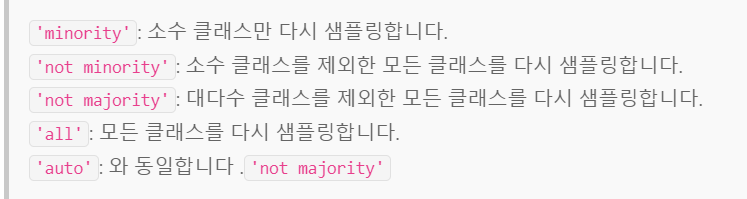

k_neighbors : 최근접 이웃의 개수, 아마 기본 smote는 5면 5개를 만드는 것으로 안다.
리샘플링 몇 개 또는 어떤방식으로 리샘플링을 만들거냐?의 방법은 아래 추가 모듈로 있다.
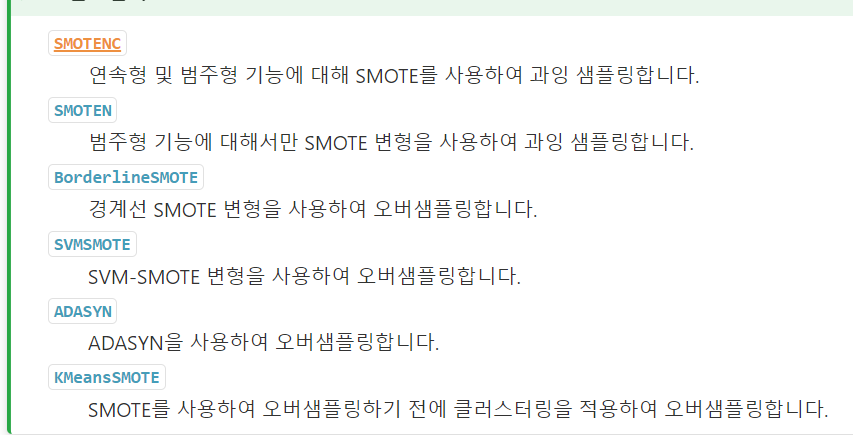

## 일단 가볍게 몸풀기로 Logistic vs smote_Logistic 비교

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
finish


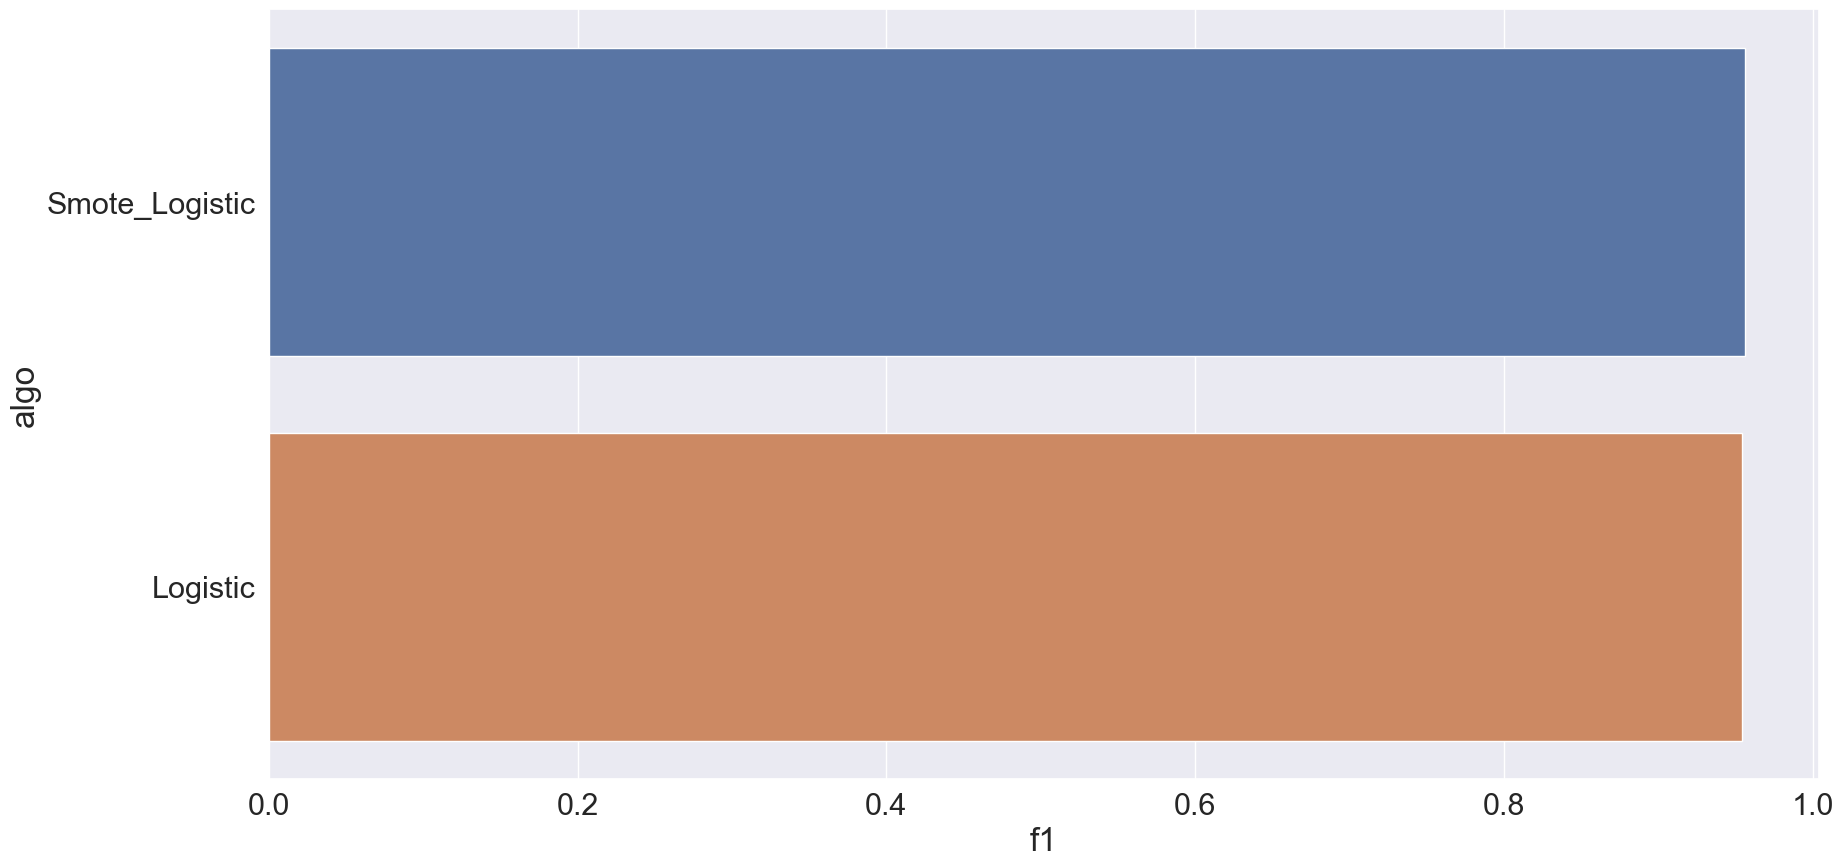

In [18]:
##### model
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression


##### sampling
from imblearn.over_sampling import SMOTE

##### pipeline
from imblearn.pipeline import Pipeline


##### dataset
X = review_df['reviews_for_vectorize']; y = review_df['label']


##### split train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)


##### cross-validation
skfold = StratifiedKFold(n_splits=5)


##### pipeline model
pipe_Logistic = Pipeline([
                ('vec', TfidfVectorizer(decode_error='ignore')),
                ('fit', LogisticRegression(solver='saga'))])


pipe_Smote_Logistic = Pipeline([
                ('vec', TfidfVectorizer(decode_error='ignore')),
                ('sampling', SMOTE(random_state=12)),
                ('fit', LogisticRegression(solver='saga'))])


##### model params -- vectorizer, smote
min_df_k = [1,5,10]
sam_str = [0.3,0.5,0.7, 'auto', 'minority', 'not majority', 'not minority', 'all']
sam_k_neighbors = [1,3,5,7,10] # kneighbors


##### set grid params
grid_params_Logistic = [{
    "vec__min_df" : ks,
    "fit__C": [5],
    "fit__solver" : ["saga"],
    "fit__penalty" : ["l2"],
    "fit__max_iter": [1000]
}]

grid_params_Smote_Logistic = [{
    "sampling__sampling_strategy" : sam_str,
    "sampling__k_neighbors" : sam_k_neighbors,
    "vec__min_df" : ks,
    "fit__C": [5],
    "fit__solver" : ["saga"],
    "fit__penalty" : ["l2"],
    "fit__max_iter": [1000]
}]


##### fit
pipe = [pipe_Logistic , pipe_Smote_Logistic ]
params = [grid_params_Logistic , grid_params_Smote_Logistic]

jobs = 20

grid_dict = {
    0: 'Logistic', 
    1: 'Smote_Logistic',
            }

model_object = {}; model_acc = {}; model_roc_auc = {}; model_f1 = {}; model_best_params = {}

#1. scoring = 'neg_mean_absolute_error' 로 설정.
# 일반적으로 scoring을 값이 클 수록 모델 성능이 좋은 것으로 사이킷런에서 인식하는데, 
# mae는 값이 클 수록 모델 성능이 저하되는 것이므로 Negative 키워드를 붙여서 사용

for idx , (param , model) in enumerate(zip(params , pipe)) :
    search = GridSearchCV(model, param, scoring  = "f1", cv=skfold,
                           n_jobs=jobs , verbose=True ) #  verbose가 있으면 함수 수행시 발생하는 상세한 정보 출력
    search.fit(X_train , y_train)
    y_pred = search.predict(X_test)
       
    model_object[grid_dict.get(idx)] = search
    model_acc[grid_dict.get(idx)] = accuracy_score(y_test, y_pred)  
    model_roc_auc[grid_dict.get(idx)] = roc_auc_score(y_test, y_pred)
    model_f1[grid_dict.get(idx)] = f1_score(y_test, y_pred)

    model_best_params[grid_dict.get(idx)] = search.best_params_
    
print("finish")

fig ,ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale = 2)
output = pd.DataFrame([model_f1.keys() , model_f1.values()], index = ["algo","f1"]).T # .T : 행 렬 변환
output.sort_values(["f1"], ascending= False ,inplace=True)
ax = sns.barplot(y="algo", x="f1", data=output)
plt.show()

In [19]:
model_acc

{'Logistic': 0.9245033112582781, 'Smote_Logistic': 0.928476821192053}

In [20]:
model_f1

{'Logistic': 0.9540939597315435, 'Smote_Logistic': 0.9561451001624255}

In [21]:
model_roc_auc

{'Logistic': 0.8443665884677121, 'Smote_Logistic': 0.8638165205580937}

In [22]:
model_best_params

{'Logistic': {'fit__C': 5,
  'fit__max_iter': 1000,
  'fit__penalty': 'l2',
  'fit__solver': 'saga',
  'vec__min_df': 1},
 'Smote_Logistic': {'fit__C': 5,
  'fit__max_iter': 1000,
  'fit__penalty': 'l2',
  'fit__solver': 'saga',
  'sampling__k_neighbors': 3,
  'sampling__sampling_strategy': 0.3,
  'vec__min_df': 1}}

 로지스틱에서 smote하니까 아주~~ 근소하게 더 좋아졌다!<br>
 로지스틱에서 smote하니까 아주~~ 근소하게 더 좋아졌다!<br>
 로지스틱에서 smote하니까 아주~~ 근소하게 더 좋아졌다!<br>
 로지스틱에서 smote하니까 아주~~ 근소하게 더 좋아졌다!<br>
 로지스틱에서 smote하니까 아주~~ 근소하게 더 좋아졌다!<br>
 로지스틱에서 smote하니까 아주~~ 근소하게 더 좋아졌다!<br>
 로지스틱에서 smote하니까 아주~~ 근소하게 더 좋아졌다!<br>
 로지스틱에서 smote하니까 아주~~ 근소하게 더 좋아졌다!<br>
 로지스틱에서 smote하니까 아주~~ 근소하게 더 좋아졌다!<br>

#  LGBM

### LGBM이란
lgbm은 Gradiant Boostid Model로 tree 기반 학습 알고리즘이다. 

쉽게 말하자면 학습을 반복하는데 전에 틀린 부분에 가중치를 줘서 더 학습에 도움이 되도록 하는 학습이다.


### LGBM의 장점 및 단점
예전에도 트리방식의 부스팅이 있었지만 다 수평 확장 모델이었다.
트리를 깊게 뿌리는 방식이 아니라 수평으로 균등하게 뿌려가며 확장하여 속도가 매우 느렸다.

하지만 lgbm은 depth, 즉, 수직 방법이다. 수평 확장방법보다 훨신 빠르고, 데이터 손실도 줄일 수 있다고한다. (왜지?)

lgbm은 데이터 규모가 작을 땐 추천하지 않는 방식이다. 
왜냐하면 lgbm은 과적합에 예민하다. (어찌보면 너무 정확하게 맞추는게 탈인 것이다.)

적어도 행이나 열이 10000개 이상 될 때 사용하는 것을 추천한다고 한다.

### LGBM의 파라미터
Light GBM은 100개 이상의 파라미터가 존재한다. ㅋㅋㅋ...
이를 다 알 수는 없다.. 중요한 하이퍼 파라미터만 봐도 충분하다.!
```
learning_rate = [0.01, 0.05, 0.1]         # 가중치 값 (일반적으로 0.1 언저리를 튜닝시키고 튜닝이 끝나고  마지막 학습때 0.05 이하를 주                                               면 좋다고 한다. 근데 gridsearch와 같은 최적화 작업을 할땐 다른파라미터에 집중하는게 좋다)

boosting_type = ['gbdt', 'dart', 'goss']  # 기본은 gbdt, 정확도가 중요할 때는 dart, 샘플링을 이용할 때는 goss.(rf : 랜덤포레스트)

metric = ['binary_logloss']               # 성능(손실) 평가 방법, 반복하며 이 스코어로 평가, 이진로그최소??, auc를 대부분 사용하더라..
                                            튜닝 가능!

num_leaves = [16,32]                      # 하나의 트리가 가질 수 있는 최대 리프 개수, 키우면 복잡해짐

n_estimators = [300,500,700]              # 부스팅 반복 횟수. 크게 지정할수록 예측 성능이 높아, 보통 수백에서 수천, 반복하니 정확도는 
                                            올라가니 좋지만 당연히 오버피팅 위험도 증가, 만약 early 반복수 와 비교해서 낮으면 바로 탈락.                                             ex)10번:검증데이터 10번 반복한 early 점수 vs 10번 마다 학습 점수 비교해서 낮으면 바로 탈락.

min_child_samples = [100, 200, 300]       # 나뭇잎 노드에서의 최소 데이터  즉, 나눌때 최소한 이정도 데이터 개수로 나눠라. 
                                            아주 큰 데이터일 경우 100~1000의 값이면 충분, 만약 낮다고 생각해보자.. 
                                            1개 라도 구분되면 짤라서 트리를 나누게 되면 트리의 깊이가 매우 깊어질 것이다.->과적합
                                            
max_depth = [default : -1]                # 트리의 최대깊이, 과적합에 가장 민감하다.(feature가 많다면 크게 설정하는 것이 좋다.)
                                           (데이터 약 10000건인 경우에 max_depth는 약 20~30 사이??)
                                           그냥 lgbm에서는 -1을 추천, 그리고 나뭇잎 수를 조정해라.
                                           
sub_feature' = 0.5                        # 샘플링 관련 파라미터, 여긴 공부 하기 싫어서 안했습니다.


fit__force_col_wise (or row) = True       # CPU 연산 관련 파라미터, True 하면 메모리 누수?로 인한 오류 잡아준다는데 암튼 키는거 추천
                                            행 데이터가 많으면 row, 열 데이터가 많으면 col
```

### LGBM의 파라미터 학습 방법
그럼 이 파라미터들을 어떻게 다룰까....?

1. 먼저 depth를 추정한다.(num_leaves는 2^(max_depth))<br><br>
num_leaves의 개수를 중심으로 min_child_sampes(min_data_in_leaf), max_depth를 함께 조절하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안
<br><br>
예를 들어 max_depth가 7일 때, 2^(max_depth)=128이 되는데, 이 때 num_leaves를 이보다 작은 70~80 정도로 설정하는 것이 낫다.
<br><br>
2. 람다와 알파는 보통 기본값인 0으로 한다
<br><br>
3. 마지막으로 learning_rate을 줄이면서 n_estimator를 크게하는 것은 부스팅에서의 기본적인 튜닝 방안

### early_stopping (valid_sets, early_stopping_rounds, eval_metrics)
##### 한마디로 반복을 중지할 수 있는 반복 검증 도구 (보통 '조기 중단' 이라고 한다.)
LGBM은 이전 학습에서 틀린 것에 가중치 줘서 다시 학습하는 반복학습의 일종이다.
따라서 반복학습에 필요없는 반복이 존재할 가능성있다.
LGBM은 이를 방지하기 위해 lightgbm에 early_stopping이라는 모듈을 탑재해 이 의미없는 반복을 없앨 수 있다.

early stop의 방식은 early 전용 데이터로 사용자가 정한 횟수 반복, 그 후 사용자가 정한 점수를 측정한다.
그리고 이 점수를 검증 점수로 사용하는 것이다.

만약에 0번:검증데이터 10번 반복한 early 점수 vs 10번 마다 학습 점수 비교해서 낮으면 바로 탈락.
ealry 횟수, 점수 낮으면 보다 낮으면 더 반복 할 필요가 없다고 판단. 학습 끝

근데 최근 early stopping이 업데이트 되었다고 한다.
구글에서 보는 많은 코드는 일단 구식 버전일 가능성이 높다..... 그래서 구글링해도 구현 하기 힘든 시기... 

### early stopping  vs gridsearch (feat. Kfold) 
##### 어찌보면.... 스코어 반복 검증 vs 교차 검증
LGBM에 파라미터가 너무많은데 언제 다돌릴 수 없다.. 당연히 pipeline 만들어 gridsearch할 생각을 하게 된다.
근데 gridsearch에 넣으면 early stopping을 사용 할 수 없다.

(깊게 말하자면 grid prams 에 넣은 파라미터가 아니다. fit() 할때 넣어야되는 함수라 넣으면 오류난다.)

아니 그럼 이 21세기에 진짜 못 사용 하냐? 물론 아니다 ㅋ 근데 사용을 할 수 있지만 커스텀해서 짜야한다...
그래서 커스텀 한 사람들 코드를 보고 댓글도 봣는데 구현은 할 수 있다만 추천은 안한다는 댓글들이 많았다.
그 이유인 즉슨, gridsearch할때 대부분 교차검증 하고자 kfold를 사용할텐데 
데이터를 나눠놓고 어? 이전보다 학습이 안되네? 반복 중지! 하면 폴드 검증에 안좋은 영향을 끼칠수도 있다? 라고 하는 사람도 있고(정확히 모르겠습니다. ㅠ) (근데 어떤사람은 fold 당 early가 적용 안된다는 사람도 있고.... 호호호 정말 모르겠다)

update.
폴드하면 데이터 5등분 -> 그럼 5등분 된 데이터를 매번 early 검증 데이터로 넣어야하는데 추적이 불가? 그래서 검증데이터로 다른 거 잡아서 하기 애매함? 아닌가... 더 좋을거 같기도 한대..?

위를 종합적으로 보면 early stopping을 사용하려면 gridsearch가 아닌 단일모델로 만들고 검증하고 싶은 교차도 하고싶으면 미리 데이터 셋을 나눠놓고.... 그 데이터셋을 early stopping 검증데이터로도 점수 검증을 하라..... 고 보면된다.

여러분을 믿습니다 저는 여기까지 요약했으니 누가 좀 알려주세요 

lgbm 파라미터 : https://zzinnam.tistory.com/entry/lightgbm-%EC%A3%BC%EC%9A%94-%ED%95%98%EC%9D%B4%ED%8D%BC%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0-with-%ED%8C%8C%EC%9D%B4%EC%8D%AC<br><br>
https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/<br><br>
https://hellominji.tistory.com/40

In [13]:
## lgbm에서 f1 score로 평가하기, 근데 이럴필요가 있나?
def f1_lgbm(y_pred, dataset):
    y_true = dataset.get_label()

    diff = abs(y_true - y_pred)
    less_then_one = np.array([0 if x < 1 else 1 for x in diff])

    y_pred = less_then_one * y_pred
    y_true = less_then_one *y_true
    
    score= f1_score(y_true, y_pred)
    
    return 'score', score, False

# Logistic vs LGBM vs Smote_Logistic vs Smote_LGBM

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 7278, number of negative: 1778
[LightGBM] [Info] Total Bins 12811
[LightGBM] [Info] Number of data points in the train set: 9056, number of used features: 254
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.803666 -> initscore=1.409367
[LightGBM] [Info] Start training from score 1.409367
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[LightGBM] [Info] Number of positive: 7278, number of negative: 7278
[LightGBM] [Info] Total Bins 35827
[LightGBM] [Info] Number of data points in the train set: 14556, number of used features: 640
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
finish


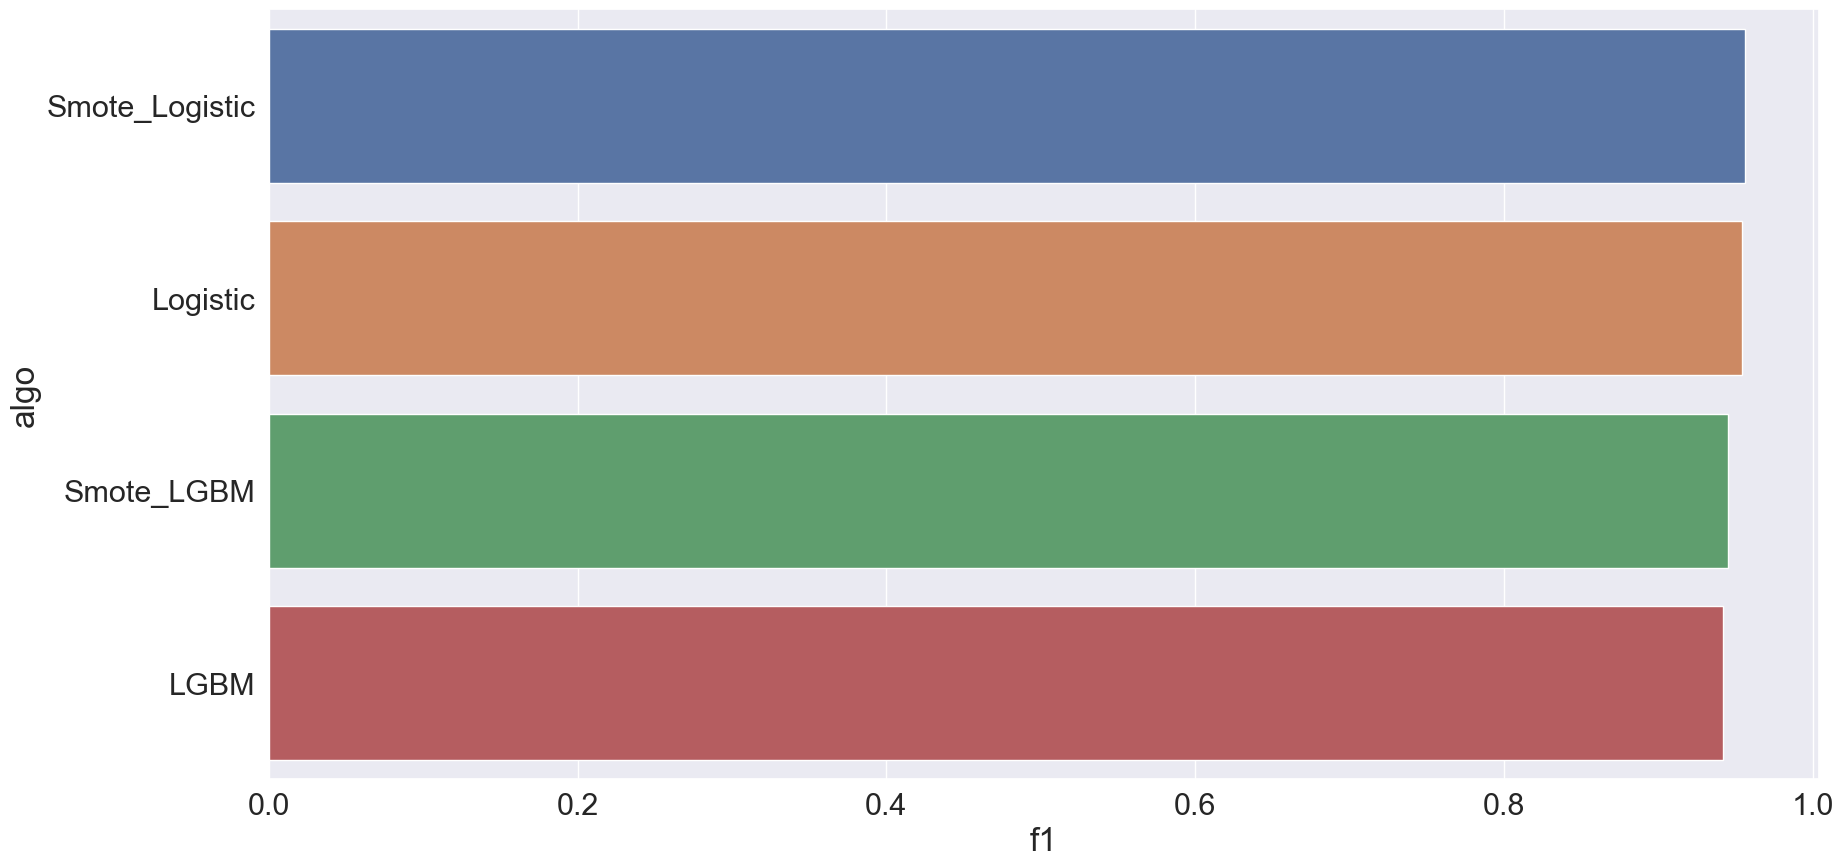

In [23]:
##### model
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression


##### sampling
from imblearn.over_sampling import SMOTE


##### pipeline
from imblearn.pipeline import Pipeline


##### dataset
X = review_df['reviews_for_vectorize']; y = review_df['label']


##### split train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)


##### cross-validation
skfold = StratifiedKFold(n_splits=5)


##### pipeline model
pipe_Logistic = Pipeline([
                ('vec', TfidfVectorizer(decode_error='ignore')),
                ('fit', LogisticRegression(solver='saga'))])

pipe_LGBM = Pipeline([
                ('vec', TfidfVectorizer(decode_error='ignore')),
                ('fit', LGBMClassifier())])

pipe_Smote_Logistic = Pipeline([
                ('vec', TfidfVectorizer(decode_error='ignore')),
                ('sampling', SMOTE(random_state=12)),
                ('fit', LogisticRegression(solver='saga'))])


pipe_Smote_LGBM = Pipeline([
                ('vec', TfidfVectorizer(decode_error='ignore')),
                ('sampling', SMOTE(random_state=12)),
                ('fit', LGBMClassifier())])


##### pipeline params -- vectorizer, smote
min_df_k = [1]
sam_str = [0.3,'auto']
sam_k_neighbors = [1,3,5] # kneighbors


##### pipeline params -- vectorizer, smote
learning_rate_lst = [0.1]                        # 나중에 0.05 이하로 돌리자.
boosting_type_lst = ['gbdt', 'dart']#, 'goss']       
metric_lst = ['binary_logloss'] #,['f1_lgbm']]             
num_leaves_lst = [16, 32] # 2의 n제곱           
n_estimators_lst = [100, 300, 500]                 # 반복 횟수 
min_child_samples_lst = [50, 100]          # 노드(나뭇잎)에 포함될 최소 데이터 개수 
max_depth_lst = [-1]                             # 트리의 최대 깊이, lgbm에서는 -1을 추천, 그리고 나뭇잎 수를 조정해라.


##### grid params
grid_params_Logistic = [{
    "vec__min_df" : min_df_k,
    "fit__C": [5],
    "fit__solver" : ["saga"],
    "fit__penalty" : ["l2"],
    "fit__max_iter": [1000]
}]

grid_params_LGBM = [{
    "vec__min_df" : min_df_k,
    'fit__objective' : ['binary'],    
    'fit__boosting_type' : boosting_type_lst,
    'fit__metric' : metric_lst,
    'fit__learning_rate' : learning_rate_lst,
    'fit__n_estimators' : n_estimators_lst,
    'fit__max_depth' : max_depth_lst,
    'fit__num_leaves' : num_leaves_lst,
    'fit__min_child_samples' : min_child_samples_lst,
    'fit__force_col_wise' : ['True']          #or 'fit__force_row_wise' 
}]

grid_params_Smote_Logistic = [{
    "sampling__sampling_strategy" : sam_str,
    "sampling__k_neighbors" : sam_k_neighbors,
    "vec__min_df" : ks,
    "fit__C": [5],
    "fit__solver" : ["saga"],
    "fit__penalty" : ["l2"],
    "fit__max_iter": [1000]
}]

grid_params_Smote_LGBM = [{
    "vec__min_df" : ks,
    "sampling__sampling_strategy" : sam_str,
    "sampling__k_neighbors" : sam_k_neighbors,
    'fit__objective' : ['binary'],    
    'fit__boosting_type' : boosting_type_lst,
    'fit__metric' : metric_lst, 
    'fit__learning_rate' : learning_rate_lst,
    'fit__n_estimators' : n_estimators_lst,
    'fit__max_depth' : max_depth_lst,
    'fit__num_leaves' : num_leaves_lst,
    'fit__min_child_samples' : min_child_samples_lst,
    'fit__force_col_wise' : ['True']     
}]


##### grid inputs
pipe = [pipe_Logistic , pipe_LGBM, pipe_Smote_Logistic, pipe_Smote_LGBM]
params = [grid_params_Logistic , grid_params_LGBM, grid_params_Smote_Logistic, grid_params_Smote_LGBM]

jobs = 20

grid_dict = {
    0: 'Logistic', 
    1: 'LGBM',
    2: 'Smote_Logistic',
    3: 'Smote_LGBM'
            }

model_object = {}; model_acc = {}; model_roc_auc = {}; model_f1 = {}; model_best_params = {}

for idx , (param , model) in enumerate(zip(params , pipe)) :
    search = GridSearchCV(model, param, scoring  = "f1", cv=skfold, error_score='raise',
                           n_jobs=jobs , verbose=True ) #  verbose가 있으면 함수 수행시 발생하는 상세한 정보 출력

    search.fit(X_train , y_train)
    y_pred = search.predict(X_test)
       
    model_object[grid_dict.get(idx)] = search
    model_acc[grid_dict.get(idx)] = accuracy_score(y_test, y_pred)  
    model_roc_auc[grid_dict.get(idx)] = roc_auc_score(y_test, y_pred)
    model_f1[grid_dict.get(idx)] = f1_score(y_test, y_pred)

    model_best_params[grid_dict.get(idx)] = search.best_params_
    
print("finish")

fig ,ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale = 2)
output = pd.DataFrame([model_f1.keys() , model_f1.values()], index = ["algo","f1"]).T # .T : 행 렬 변환
output.sort_values(["f1"], ascending= False ,inplace=True)
ax = sns.barplot(y="algo", x="f1", data=output)
plt.show()

In [24]:
model_acc

{'Logistic': 0.9245033112582781,
 'LGBM': 0.9041942604856512,
 'Smote_Logistic': 0.928476821192053,
 'Smote_LGBM': 0.9108167770419426}

In [25]:
model_f1

{'Logistic': 0.9540939597315435,
 'LGBM': 0.9421178981061616,
 'Smote_Logistic': 0.9561451001624255,
 'Smote_LGBM': 0.9448689956331878}

In [26]:
model_roc_auc

{'Logistic': 0.8443665884677121,
 'LGBM': 0.8020187677491047,
 'Smote_Logistic': 0.8638165205580937,
 'Smote_LGBM': 0.8485831584146191}

In [27]:
model_best_params

{'Logistic': {'fit__C': 5,
  'fit__max_iter': 1000,
  'fit__penalty': 'l2',
  'fit__solver': 'saga',
  'vec__min_df': 1},
 'LGBM': {'fit__boosting_type': 'gbdt',
  'fit__force_col_wise': 'True',
  'fit__learning_rate': 0.1,
  'fit__max_depth': -1,
  'fit__metric': 'binary_logloss',
  'fit__min_child_samples': 50,
  'fit__n_estimators': 100,
  'fit__num_leaves': 32,
  'fit__objective': 'binary',
  'vec__min_df': 1},
 'Smote_Logistic': {'fit__C': 5,
  'fit__max_iter': 1000,
  'fit__penalty': 'l2',
  'fit__solver': 'saga',
  'sampling__k_neighbors': 3,
  'sampling__sampling_strategy': 0.3,
  'vec__min_df': 1},
 'Smote_LGBM': {'fit__boosting_type': 'dart',
  'fit__force_col_wise': 'True',
  'fit__learning_rate': 0.1,
  'fit__max_depth': -1,
  'fit__metric': 'binary_logloss',
  'fit__min_child_samples': 50,
  'fit__n_estimators': 500,
  'fit__num_leaves': 16,
  'fit__objective': 'binary',
  'sampling__k_neighbors': 5,
  'sampling__sampling_strategy': 'auto',
  'vec__min_df': 1}}

In [28]:
lgbm_model = model_object["LGBM"].best_estimator_.named_steps.fit
lgbm_model.get_params(deep=True)

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 50,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 32,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'force_col_wise': 'True',
 'metric': 'binary_logloss'}

In [29]:
Smote_lgbm_model = model_object["Smote_LGBM"].best_estimator_.named_steps.fit
Smote_lgbm_model.get_params(deep=True)

{'boosting_type': 'dart',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 50,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'num_leaves': 16,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'force_col_wise': 'True',
 'metric': 'binary_logloss'}

In [33]:
lgbm_model

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': -1,
 'min_child_samples': 100,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'num_leaves': 16,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'binary_logloss'}

# 학습 파이프라인
- 로지스틱은 저번 모델 고정
- smote에 파라미터를 정해놓고 베스트 모델을 추출해보자

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits


C:\Users\Sam\miniconda3\envs\ds_study\lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


finish


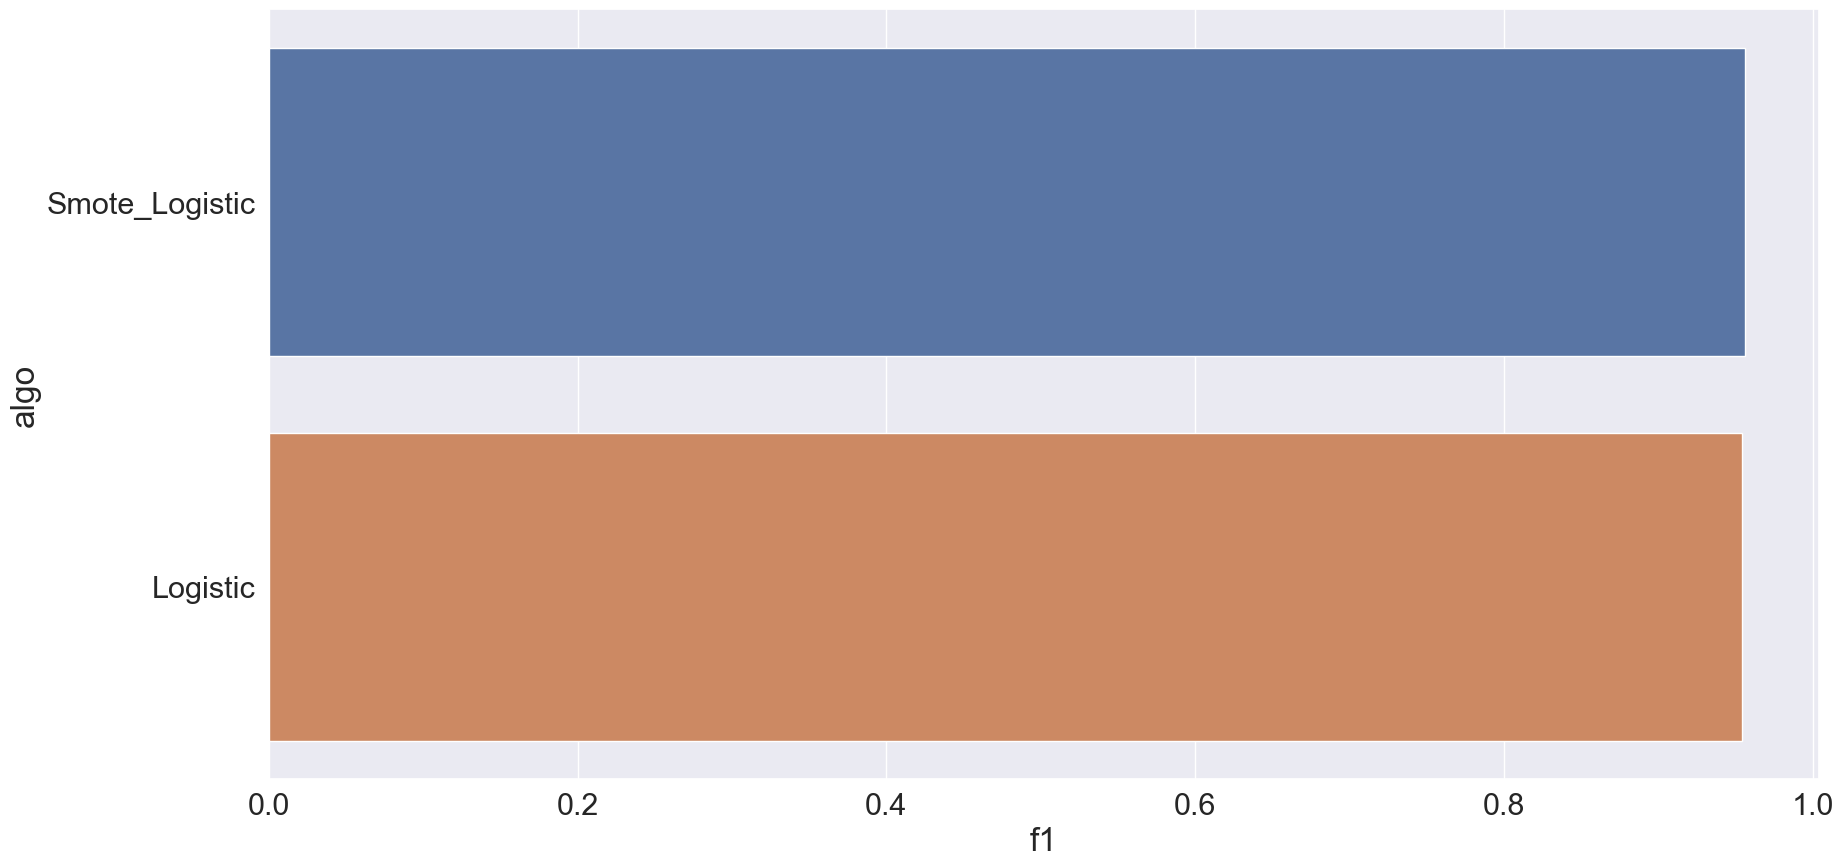

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV

#from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.metrics import a

dd = SMOTE()

X = review_df['reviews_for_vectorize']
y = review_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

skfold = StratifiedKFold(n_splits=5)

pipe_Logistic = Pipeline([
                ('vec', TfidfVectorizer(decode_error='ignore')),
                ('fit', LogisticRegression())])

pipe_Smote_Logistic = Pipeline([
                ('vec', TfidfVectorizer(decode_error='ignore')),
                ('sampling', SMOTE(random_state=12,n_jobs=20)),
                ('fit', LogisticRegression())])


# 이진분류일때 smote 전략에 float 써서 비율을 정해줄수 있음(다분류에서는 에러 뜰 확률이 높다합니다.)
# ex) sampling_strategy=0.4  ==> 소수/다수 = 0.4가 되도록 비율을 맞춰준다 
# minority : 소수 피쳐를 오버샘플링해서 (복원 추출) 다수 피쳐 데이터수와 동일하게 맞추게 됩니다.
# auto는 자동최적화.....?

#sam_str = ['auto']
sam_str = [0.3,0.5,0.7, 'auto', 'minority', 'not majority', 'not minority', 'all']
sam_k_neighbors = [1,3,5,7,10] # kneighbors
k = [1,5,10]

voca = nouns_list_set

grid_params_Logistic = [{
    "vec__min_df" : k,
    "fit__C": [5],
    "fit__solver" : ["saga"],
    "fit__penalty" : ["l2"],
    "fit__max_iter": [1000]
}]

grid_params_Smote_Logistic = [{
    "sampling__sampling_strategy" : sam_str,
    "sampling__k_neighbors" : sam_k_neighbors,
    "vec__min_df" : k,
    "fit__C": [5],
    "fit__solver" : ["saga"],
    "fit__penalty" : ["l2"],
    "fit__max_iter": [1000]
}]


pipe = [pipe_Logistic , pipe_Smote_Logistic ]
params = [grid_params_Logistic , grid_params_Smote_Logistic]

jobs = 20

grid_dict = {
    0: 'Logistic', 
    1: 'Smote_Logistic',
            }

model_object = {}; model_acc = {}; model_preci = {}; model_recall = {}; model_f1 = {}; model_best_params = {}

for idx , (param , model) in enumerate(zip(params , pipe)) :
    search = GridSearchCV(model, param, scoring  = "f1", cv=skfold, error_score='raise',
                           n_jobs=jobs , verbose=True ) #  verbose가 있으면 함수 수행시 발생하는 상세한 정보 출력
    search.fit(X_train , y_train)
    y_pred = search.predict(X_test)
       
    model_object[grid_dict.get(idx)] = search
    model_acc[grid_dict.get(idx)] = accuracy_score(y_test, y_pred)  
    model_preci[grid_dict.get(idx)] = precision_score(y_test, y_pred)
    model_recall[grid_dict.get(idx)] = recall_score(y_test, y_pred)
    model_f1[grid_dict.get(idx)] = f1_score(y_test, y_pred)

    model_best_params[grid_dict.get(idx)] = search.best_params_
    
print("finish")

fig ,ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale = 2)
output = pd.DataFrame([model_f1.keys() , model_f1.values()], index = ["algo","f1"]).T # .T : 행 렬 변환
output.sort_values(["f1"], ascending= False ,inplace=True)
ax = sns.barplot(y="algo", x="f1", data=output)
plt.show()

In [24]:
model_acc

{'Logistic': 0.9245033112582781, 'Smote_Logistic': 0.928476821192053}

In [25]:
model_f1

{'Logistic': 0.9540939597315435, 'Smote_Logistic': 0.9561451001624255}

In [26]:
model_

{'Logistic': 0.9245033112582781, 'Smote_Logistic': 0.928476821192053}

In [27]:
model_best_params

{'Logistic': {'fit__C': 5,
  'fit__max_iter': 1000,
  'fit__penalty': 'l2',
  'fit__solver': 'saga',
  'vec__min_df': 1},
 'Smote_Logistic': {'fit__C': 5,
  'fit__max_iter': 1000,
  'fit__penalty': 'l2',
  'fit__solver': 'saga',
  'sampling__k_neighbors': 3,
  'sampling__sampling_strategy': 0.3,
  'vec__min_df': 1}}